## Libraries imports

In [88]:
import pandas as pd
import numpy as np

import seaborn as sn
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.decomposition import KernelPCA
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

## Data imports

In [2]:
data = pd.read_csv("/content/drive/MyDrive/Statapp/data_02.csv")

<ipython-input-2-7ad2a7d11041>:1: DtypeWarning: Columns (6129) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("/content/drive/MyDrive/Statapp/data_02.csv")


Let us gather the useful health-related variables.

Categorical variables:
- RwHOMCAR: indicates whether the Respondent reports any home health care in the reference period. '1' for 'yes', '0' for 'no'.
- RwHIBP: indicates whether the Respondent presents High blood pressure or hypertension. '1' for 'yes', '0' for 'no'.
- RwDIAB: indicates whether the Respondent presents diabete or high blood sugar. '1' for 'yes', '0' for 'no'.
- RwHEART: indicates whether the Respondent presents heart-related problems. '1' for 'yes', '0' for 'no'.
- RwSTROK: indicates whether the Respondent presents stroke or transient ischemic attack. '1' for 'yes', '0' for 'no'.
- RwPSYCH: indicates whether the Respondent presents emotional, nervous or psychiatric problems. '1' for 'yes', '0' for 'no'.
- RwDRINK: indicates whether the Respondent drinks any alcool. '1' for 'yes', '0' for 'no'.
- RwSMOKEN: indicates whether the Respondent smokes any cigarette now. '1' for 'yes', '0' for 'no'.
- RwSMOKEV: indicates whether the Respondent ever smoke any cigarette now. '1' for 'yes', '0' for 'no'.
- RwSLFMEM: provides a measure of self reported general rating of memory, from 1 being the best to 5 being the worst rating.

Quantitative variables:
- RwHSPTIM: provides the number of overnight stays at the hospital since the last interview.
- RwNRSTIM: provides the number of overnight nursing home stays since the last interview.
- RwBMI: provides Body Mass Index of the respondent.
- RwAGEY_B: provides the age in years of the respondent.

we will only use these variables for now.

In [15]:
binary_variables = ["HOMCAR","HIBP","DIAB",
                  "HEART","STROK","PSYCH","DRINK",
                  "SMOKEN", "SMOKEV"]
non_binary_categorical_variables = ["SLFMEM"]
quantitative_variables = ["HSPTIM","NRSTIM","BMI","AGEY_B"]
in_waves = [f"INW{wave}" for wave in range(1, 15)]


In [16]:
health_columns_to_keep = ['R'+str(wave)+var for wave in range(1, 15) for var in binary_variables+non_binary_categorical_variables+quantitative_variables]
health_columns_possible_to_keep = list(set(health_columns_to_keep) & set(data.columns)) # Some column may be missing in the database

health_data = data[["HHIDPN"]+health_columns_possible_to_keep+in_waves]

In [17]:
print(health_data.shape)
health_data.head()

(42233, 211)


,HHIDPN,R1NRSTIM,R11NRSTIM,R2SMOKEN,R8SMOKEN,R3DIAB,R12AGEY_B,R10HOMCAR,R3HIBP,R4DIAB,...,INW5,INW6,INW7,INW8,INW9,INW10,INW11,INW12,INW13,INW14
0,1010,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
1,2010,0.0,NaN,1.0,NaN,0.0,NaN,NaN,0.0,0.0,...,1,0,0,0,0,0,0,0,0,0
2,3010,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,...,1,1,1,1,1,1,1,0,0,0
3,3020,0.0,0.0,0.0,0.0,0.0,75.0,0.0,0.0,0.0,...,1,1,1,1,1,1,1,1,0,0
4,10001010,0.0,0.0,0.0,0.0,0.0,74.0,0.0,0.0,0.0,...,1,1,1,1,1,1,1,1,1,0


In [26]:
def get_wave(df, wave):
  if 1 <= wave and wave < 10:
    columns_of_wave = [col for col in df.columns if col[1] == str(wave) and col[2] not in "01234"]
  elif wave >= 10 and wave < 15:
    columns_of_wave = [col for col in df.columns if col[1:3] == str(wave)]
  else:
    raise Exception("wave must be between 1 and 14 (included).")

  return df.loc[df[f"INW{wave}"]==1, columns_of_wave+["HHIDPN"]]

In [109]:
data_wave1 = get_wave(health_data, 1)

In [29]:
data_wave1.shape

(12652, 15)

## Preprocessing

In [105]:
X = get_wave(health_data, 1).drop(columns=["HHIDPN"]).values

In [106]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [107]:
imp_mean = IterativeImputer(random_state=0)
X_imputed = imp_mean.fit_transform(X_scaled)

## PCA

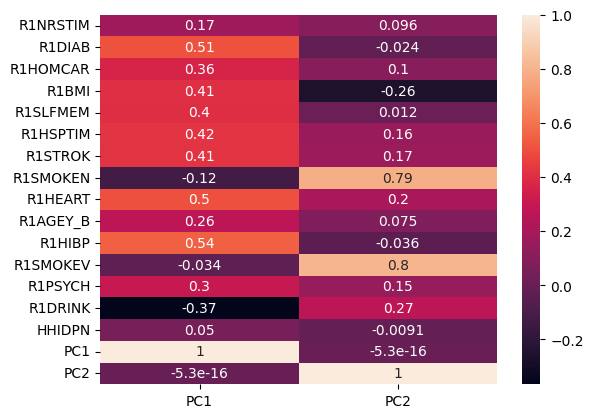

In [110]:
linearPCA = PCA(n_components = 2)
X_PCA = linearPCA.fit_transform(X_imputed)

data_wave1["PC1"] = X_PCA[:, 0]
data_wave1["PC2"] = X_PCA[:, 1]

sn.heatmap(data_wave1.corr()[["PC1", "PC2"]], annot=True)
plt.show()

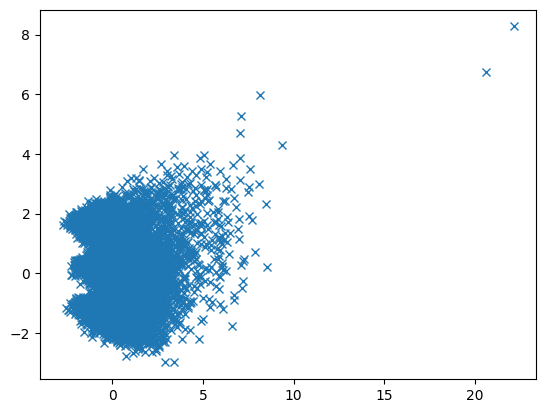

In [102]:
plt.plot(X_PCA[:, 0], X_PCA[:, 1], marker='x', ls='')
plt.show()

In [120]:
linearPCA.explained_variance_ratio_

array([0.13909473, 0.11107149])

## kernel PCA

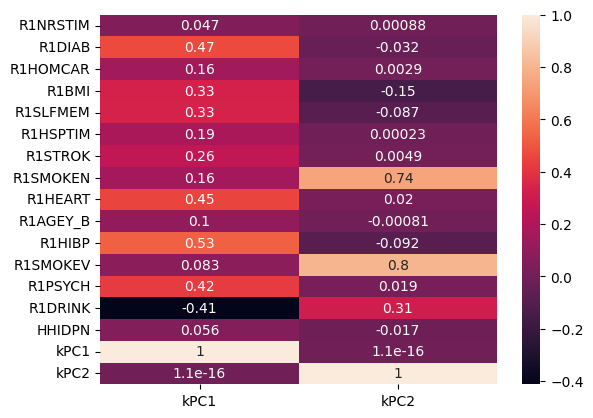

In [111]:
kPCA = KernelPCA(n_components = 2, kernel='rbf')
X_kPCA = kPCA.fit_transform(X_imputed)

data_wave1 = get_wave(health_data, 1)
data_wave1["kPC1"] = X_kPCA[:, 0]
data_wave1["kPC2"] = X_kPCA[:, 1]

sn.heatmap(data_wave1.corr()[["kPC1", "kPC2"]], annot=True)
plt.show()

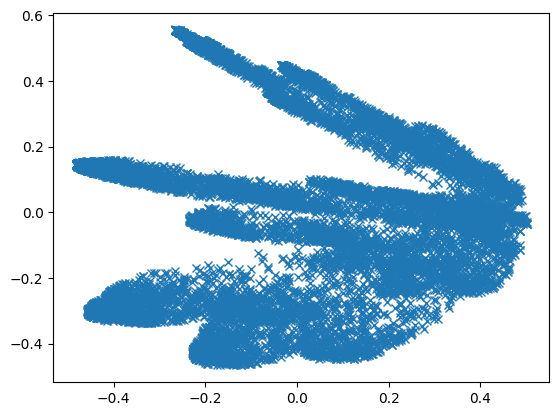

In [112]:
plt.plot(X_kPCA[:, 0], X_kPCA[:, 1], marker='x', ls='')
plt.show()

## t-SNE

In [90]:
tSNE = TSNE(n_components=2)
X_embedded = tSNE.fit_transform(X_imputed)

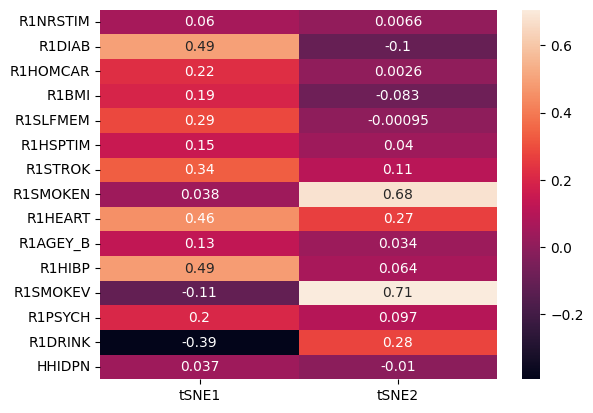

In [92]:
data_wave1["tSNE1"] = X_embedded[:, 0]
data_wave1["tSNE2"] = X_embedded[:, 1]

sn.heatmap(data_wave1.corr().iloc[:-6, -2:], annot=True)
plt.show()

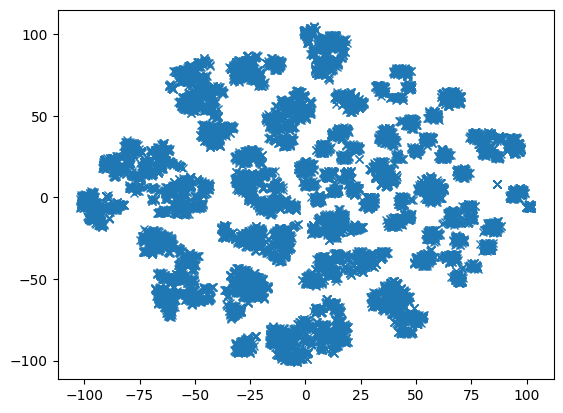

In [98]:
plt.plot(X_embedded[:, 0], X_embedded[:, 1], marker='x', ls='')
plt.show()